# Project: Adversarial BayesFlow

# Experiment 3: Diffusion Model

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats

from numba import njit

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel

from abf_functions import *

FILEFORMAT = 'png'

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------

    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------

    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """

    # Prior ranges for the simulator
    # v_c ~ U(-7.0, 7.0)
    # a_c ~ U(0.1, 4.0)
    # t0 ~ U(0.1, 3.0)
    p_samples = np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 0.1),
                                  high=(7.0, 7.0, 4.0, 4.0, 3.0), size=(batch_size, 5))
    return p_samples.astype(np.float32)


@njit
def diffusion_trial(v, a, ndt, zr, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * zr

    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    return rt + ndt if x > 0. else -rt - ndt

@njit
def diffusion_condition(n_trials, v, a, ndt, zr=0.5, dt=0.005, max_steps=1e4):
    """Simulates a diffusion process over an entire condition."""

    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, ndt, zr, dt, max_steps)
    return x


@njit
def diffusion_2_conds(params, n_trials, dt=0.005, max_steps=1e4):
    """
    Simulates a diffusion process for 2 conditions with 5 parameters (v1, v2, a1, a2, ndt).
    """

    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]

    v1, v2, a1, a2, ndt = params
    rt_c1 = diffusion_condition(n_trials_c1, v1, a1, ndt,  dt=dt, max_steps=max_steps)
    rt_c2 = diffusion_condition(n_trials_c2, v2, a2, ndt, dt=dt, max_steps=max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts


def batch_simulator(prior_samples, n_obs, dt=0.005, s=1.0, max_iter=1e4):
    """
    Simulate multiple diffusion_model_datasets.
    """

    n_sim = prior_samples.shape[0]
    sim_data = np.empty((n_sim, n_obs), dtype=np.float32)

    n1 = n_obs//2
    n2 = n_obs - n1

    # Simulate diffusion data
    for i in range(n_sim):
        sim_data[i] = diffusion_2_conds(prior_samples[i], (n1, n2))

    # Create condition labels
    cond_arr = np.stack(n_sim * [np.concatenate((np.zeros(n1), np.ones(n2)))] )
    sim_data = np.stack((sim_data, cond_arr), axis=-1)

    return sim_data

In [3]:
D = 5  # 5 parameters in total

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 128},
    'dense_s2_args': {'activation': 'relu', 'units': 128},
    'dense_s3_args': {'activation': 'relu', 'units': 128},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D*2,  # twice the required
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 5,
    'alpha': 1.9,
    'permute': True
}


inference_net = InvertibleNetwork(inference_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)

generative_model = GenerativeModel(prior, batch_simulator)

trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path='export_ckpt/mmd/ddm',
                      max_to_keep = 2
                     )

Networks loaded from export_ckpt/mmd/ddm/ckpt-75


In [4]:
# losses = trainer.train_online(epochs=75, iterations_per_epoch=1000, batch_size=64, n_obs=100)

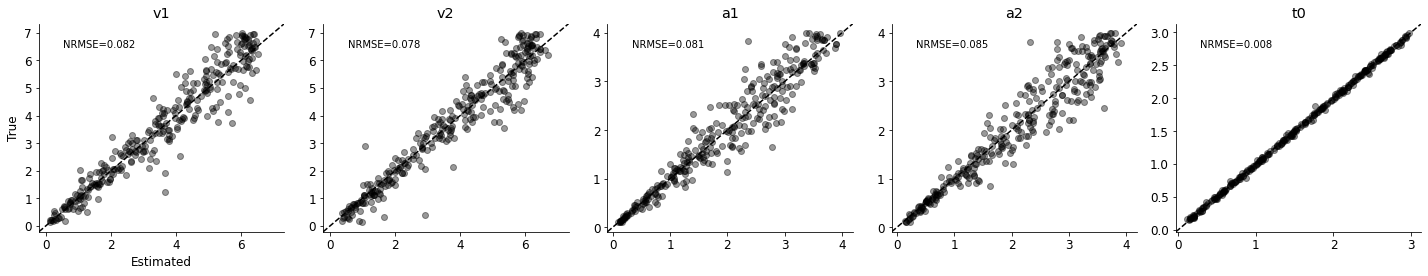

In [5]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(300, 100)
param_samples = trainer.network.sample(x, n_samples=2000)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['v1', 'v2', 'a1', 'a2', 't0'], figsize=(20,4))

In [6]:
def contamination_dist_fast_guesses(percentiles, n):    
    return np.random.uniform(0.0, percentiles[10], n)

def contamination_dist_slow_responses(percentiles, n):
    return np.random.uniform(percentiles[75], 10.0, n)

def contamination_dist_fast_and_slow(percentiles, n):
    n1 = int(n/2)
    n2 = n-n1
    fast = contamination_dist_fast_guesses(percentiles, n1)
    slow = contamination_dist_slow_responses(percentiles, n2)
    return np.concatenate((fast, slow))

def contaminate(x, contamination_dist, c=0.1):
    """
    Contaminate the random variate vector x with contaminants according to fraction c \in [0, 1]
    """
    #x_contamination = x.copy()
    
    if not x.size > 0:
        return x

    
    n = x.shape[0]
    n_contamination = int(n * c)
    contamination_idx = np.random.default_rng().choice(n, size=n_contamination, replace=False)
    
    percentiles = np.percentile(x, range(101))
    
    sampled_contamination = contamination_dist(percentiles, n_contamination)
    assert sampled_contamination.shape[0] == n_contamination
    
    
    x[contamination_idx] = sampled_contamination
    return x

def split_posneg_contaminate(x, contamination_dist, c):
    pos_idx = np.where(x>=0)
    neg_idx = np.where(x<0)
    
    x[pos_idx] = contaminate(x[pos_idx], contamination_dist=contamination_dist, c=c)
    x[neg_idx] = contaminate(x[neg_idx], contamination_dist=contamination_dist, c=c)

    
    return x


def contaminate_dm_data(x, contamination_dist, c=0.1):
    x_copy = x.copy()
    n_sim, n_obs, data_dim = x_copy.shape
    for bi in range(n_sim):
        x_copy[bi, :(n_obs//2), 0] = split_posneg_contaminate(x_copy[bi, :(n_obs//2), 0], contamination_dist, c=c)
        x_copy[bi, (n_obs//2):, 0] = split_posneg_contaminate(x_copy[bi, (n_obs//2):, 0], contamination_dist, c=c)
    return x_copy

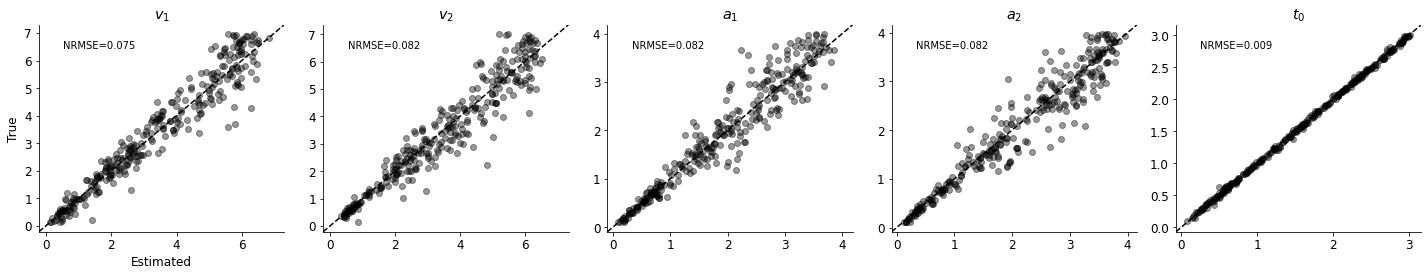

In [18]:
# Baseline
theta, x = trainer._forward_inference(300, 100)

param_samples = trainer.network.sample(x, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                 filename=f'plots/abf_dm_true_est_baseline.{FILEFORMAT}')


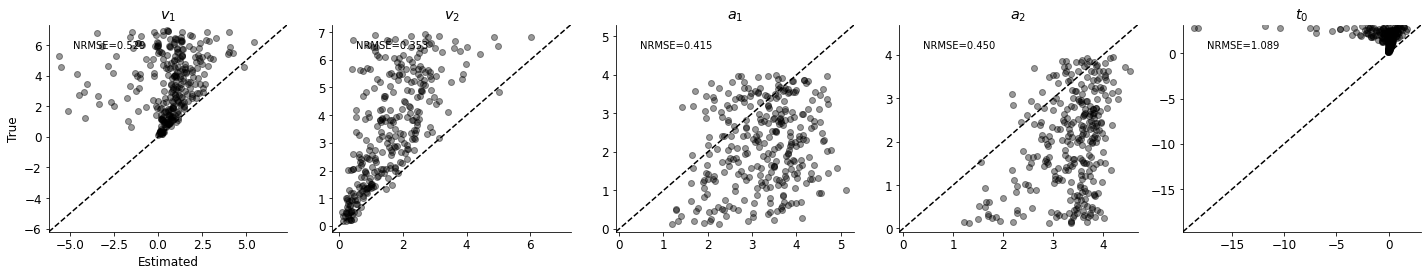

In [19]:
# Fast guesses
theta, x = trainer._forward_inference(300, 100)
x_o = contaminate_dm_data(x, contamination_dist=contamination_dist_fast_guesses, c=0.1)

param_samples = trainer.network.sample(x_o, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                 filename=f'plots/abf_dm_true_est_fast.{FILEFORMAT}')

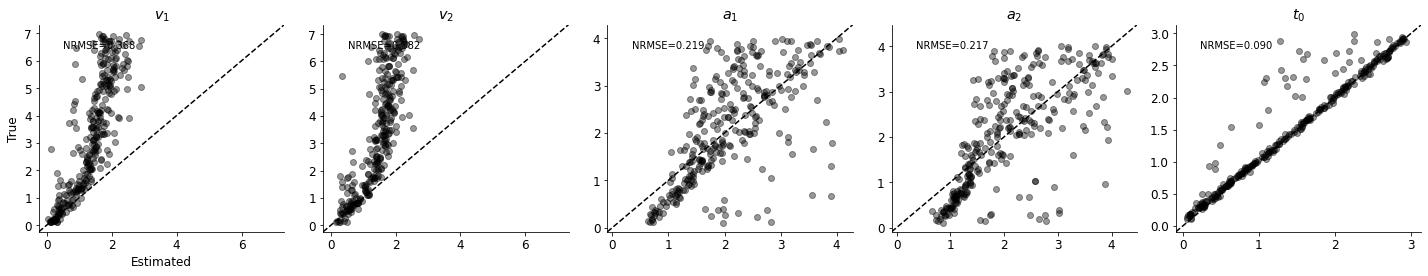

In [20]:
# Slow responses
theta, x = trainer._forward_inference(300, 100)
x_o = contaminate_dm_data(x, contamination_dist=contamination_dist_slow_responses, c=0.1)

param_samples = trainer.network.sample(x_o, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                  filename=f'plots/abf_dm_true_est_slow.{FILEFORMAT}')

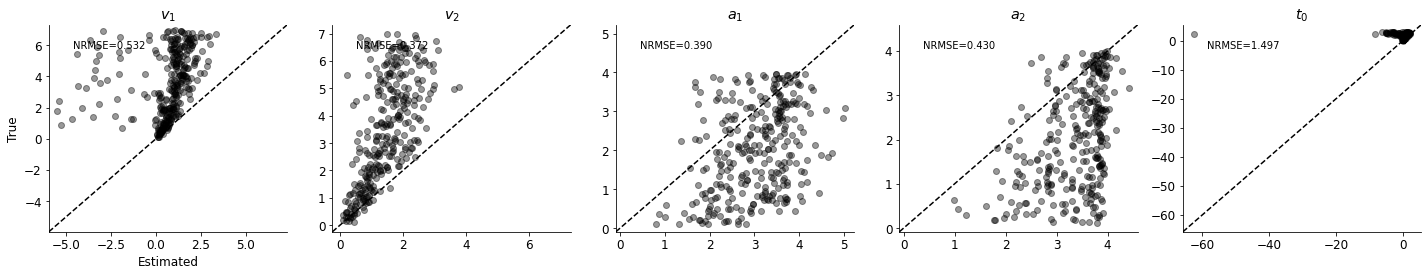

In [21]:
# Fast guesses and slow responses
theta, x = trainer._forward_inference(300, 100)
x_o = contaminate_dm_data(x, contamination_dist=contamination_dist_fast_and_slow, c=0.1)

param_samples = trainer.network.sample(x_o, n_samples=2000)
param_means = param_samples.mean(axis=0)

true_vs_estimated(theta, param_means, [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$t_0$'], figsize=(20,4),
                 filename=f'plots/abf_dm_true_est_fast_slow.{FILEFORMAT}')

In [11]:
def mahalanobis_distance_2D_1D(data, ref, cov):
    n = data.shape[0]
    mahalanobis_distances = [scipy.spatial.distance.mahalanobis(data[i], ref, cov) for i in range(n)]
    return np.array(mahalanobis_distances)

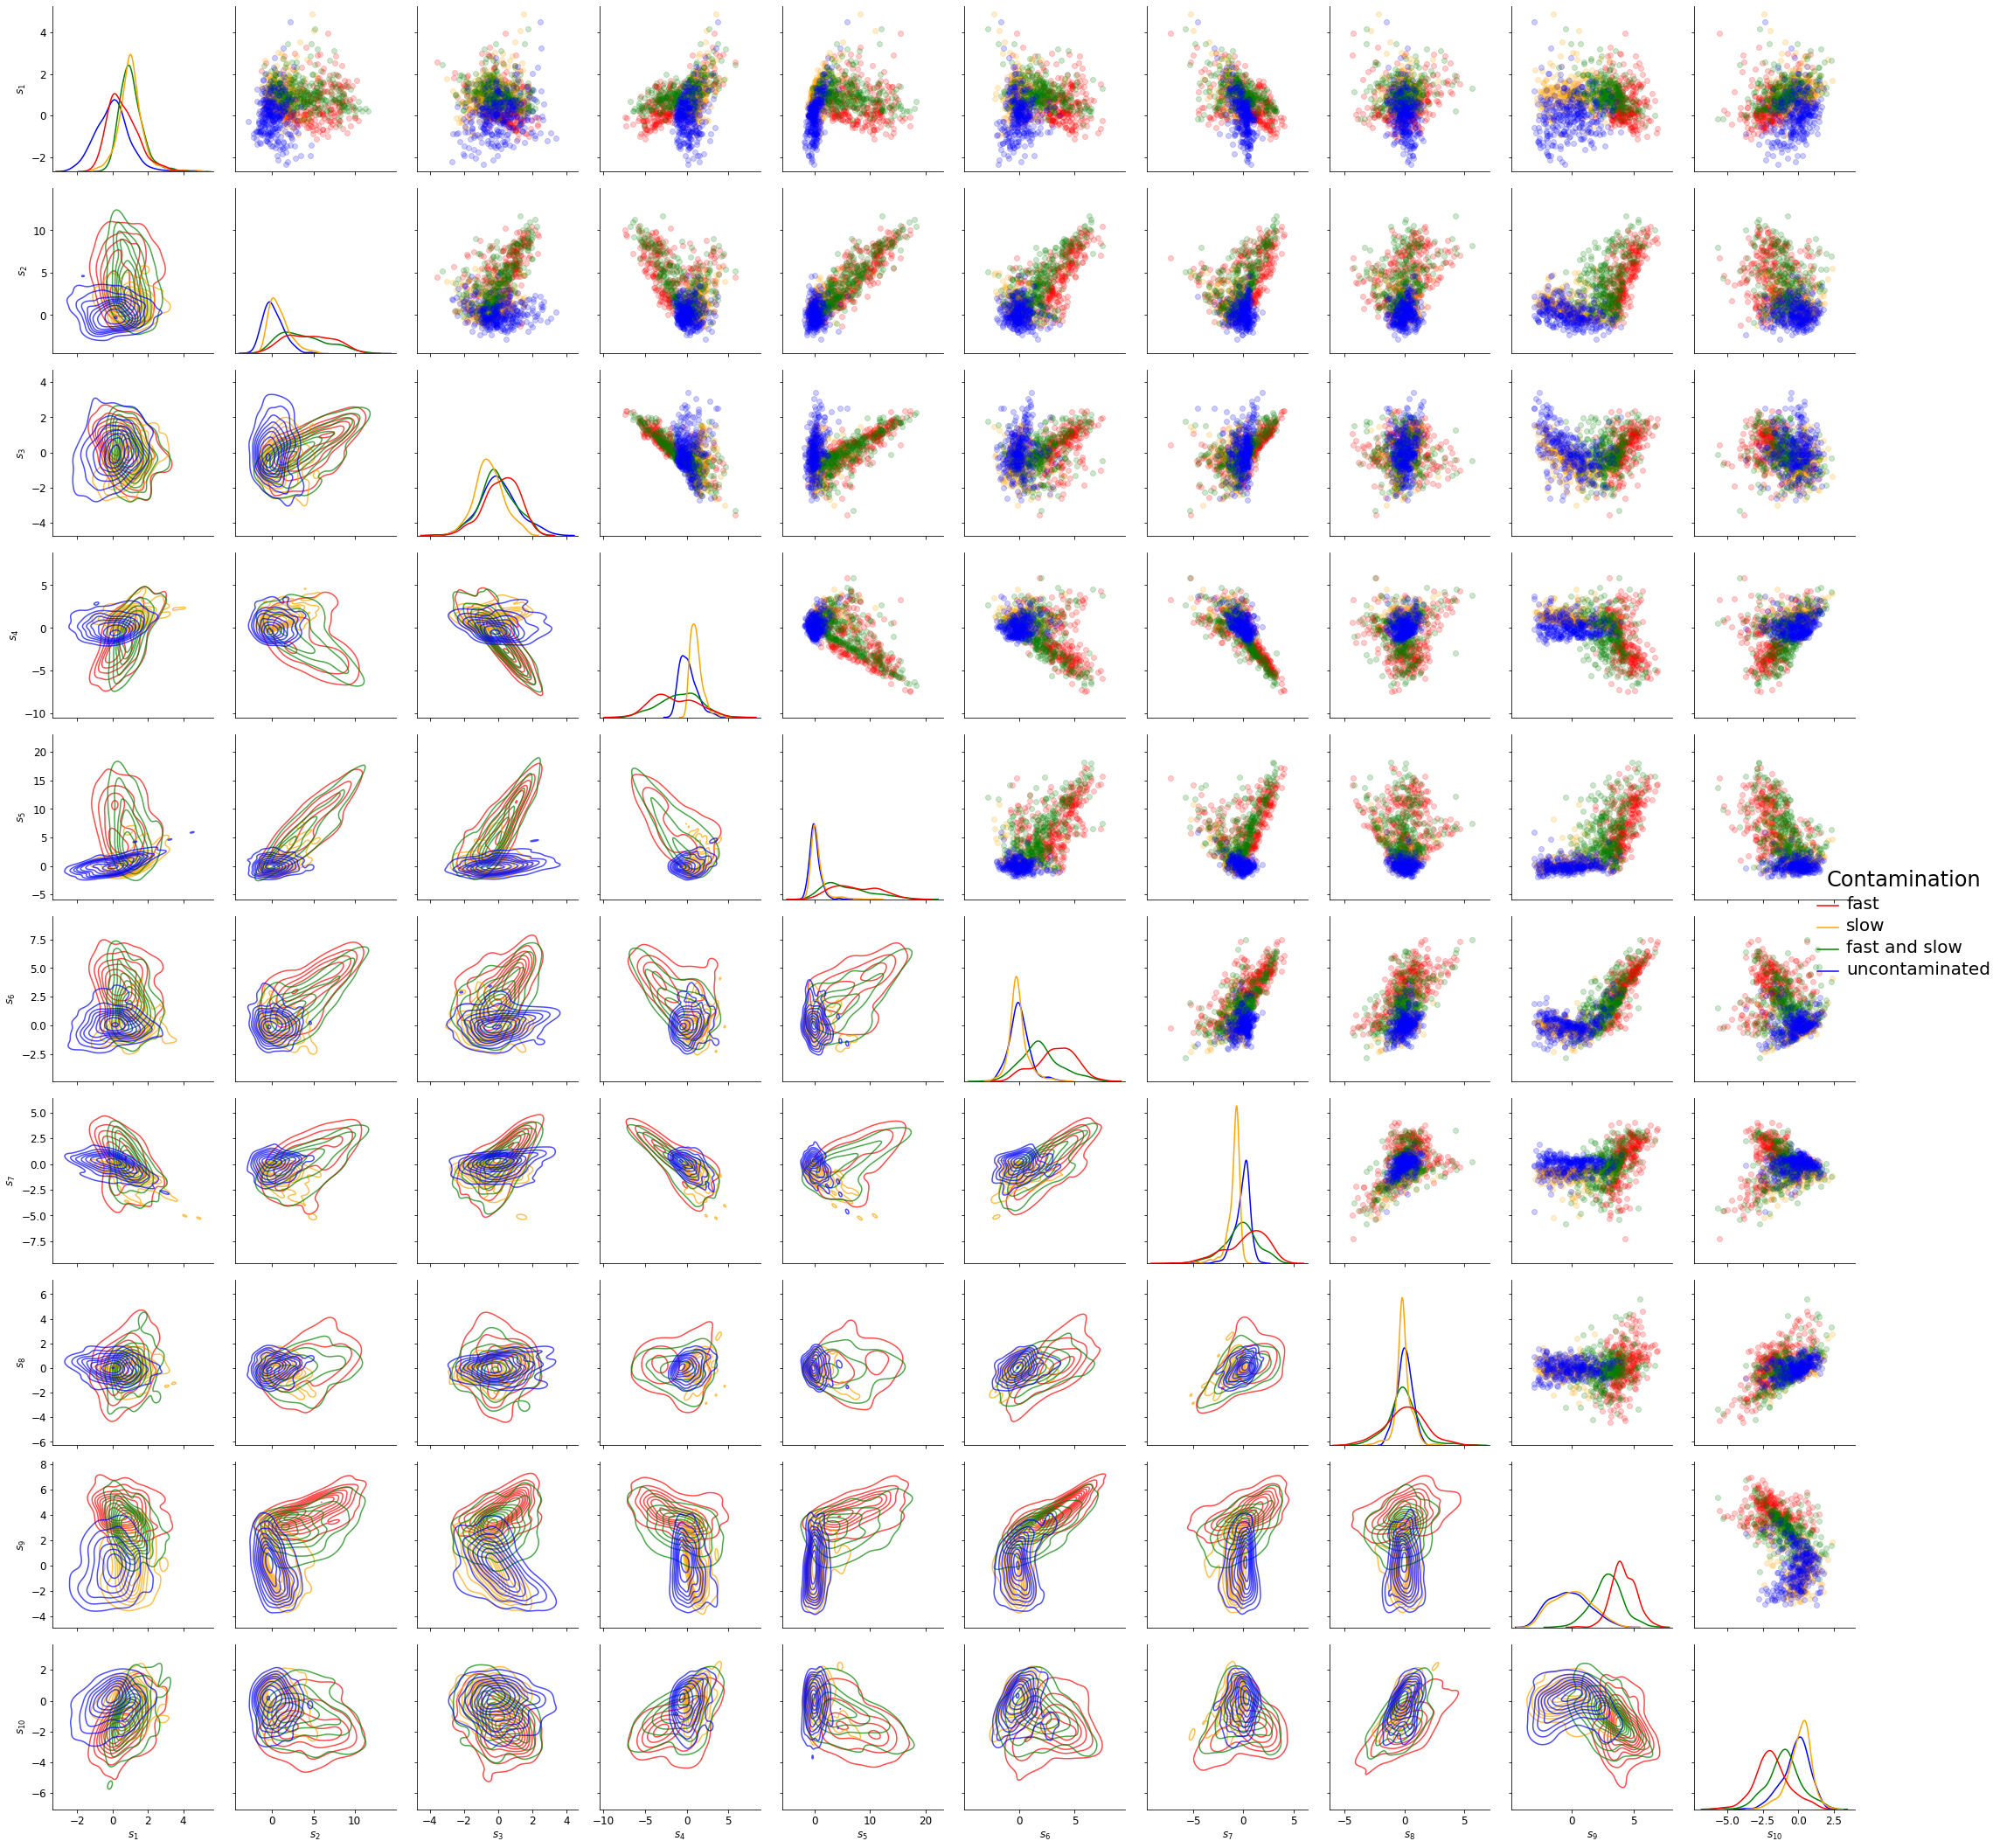

In [29]:
# Pairplot of summary network outputs
theta, x_uncontaminated = trainer._forward_inference(300, 100)

x_o_fast = contaminate_dm_data(x_uncontaminated, contamination_dist=contamination_dist_fast_guesses, c=0.1)
x_o_slow = contaminate_dm_data(x_uncontaminated, contamination_dist=contamination_dist_slow_responses, c=0.1)
x_o_fast_slow = contaminate_dm_data(x_uncontaminated, contamination_dist=contamination_dist_fast_and_slow, c=0.1)

X = [x_o_fast, x_o_slow, x_o_fast_slow, x_uncontaminated]
TASK_NAMES = ['fast', 'slow', 'fast and slow', 'uncontaminated']

DF = (pd.DataFrame(np.array(trainer.network.summary_net(x)), 
                     columns=[r'$s_{%i}$'%i for i in range(1, 11)]) for x in X)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Contamination', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Contamination", palette=['red', 'orange', 'green', 'blue'], height=3)

g.map_upper(plt.scatter, alpha=0.2)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.70)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=24)
plt.setp(g._legend.get_texts(), fontsize=20)

plt.savefig(f"plots/abf_dm_summary_pairplot.{FILEFORMAT}")

In [13]:
def dm_contamination_MD_analysis(theta, x, contamination_distribution):
    z_psi = np.array(trainer.network.summary_net(x))

    mu_z_psi = np.mean(z_psi, axis=0)
    cov_z_psi = np.cov(z_psi, rowvar=False)

    C = np.linspace(0.0, 1.0, num=11)
    MD_mean, MD_std = np.zeros_like(C), np.zeros_like(C)

    for i, c in enumerate(C):
        x_o = contaminate_dm_data(x, contamination_dist=contamination_distribution, c=c)
        s_o = np.array(trainer.network.summary_net(x_o))
        m = mahalanobis_distance_2D_1D(s_o, mu_z_psi, cov_z_psi)
        MD_mean[i] = np.mean(m)
        MD_std[i] = np.std(m)

    return C, MD_mean, MD_std

theta, x = trainer._forward_inference(300, 100) 
C, MD_mean_fast, MD_std_fast = dm_contamination_MD_analysis(theta, x, contamination_dist_fast_guesses)
C, MD_mean_slow, MD_std_slow = dm_contamination_MD_analysis(theta, x, contamination_dist_slow_responses)
C, MD_mean_fast_slow, MD_std_fast_slow = dm_contamination_MD_analysis(theta, x, contamination_dist_fast_and_slow)

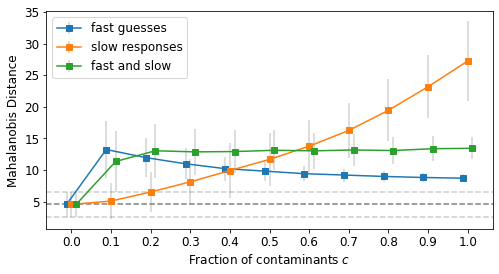

In [25]:
offset=.012

plt.figure(figsize=(8, 4))

plt.axhline(y=MD_mean_fast[0]+MD_std_fast[0], color="gray", ls="--", alpha=.40)
plt.axhline(y=MD_mean_fast[0]-MD_std_fast[0], color="gray", ls="--", alpha=.40)
plt.axhline(y=MD_mean_fast[0], ls="--", color="gray")

plt.errorbar(C[0:]-offset, MD_mean_fast[0:], yerr=MD_std_fast[0:], marker='s', ecolor='lightgray', label = "fast guesses")
plt.errorbar(C[0:], MD_mean_slow[0:], yerr=MD_std_slow[0:], marker='s', ecolor='lightgray', label = "slow responses")
plt.errorbar(C[0:]+offset, MD_mean_fast_slow[0:], yerr=MD_std_fast_slow[0:], marker='s', ecolor='lightgray', label = "fast and slow")

plt.xlabel(r"Fraction of contaminants $c$")
plt.ylabel("Mahalanobis Distance")
# plt.ylim(0)
plt.xticks(C)
plt.legend(loc='upper left')
plt.savefig(f"plots/abf_dm_md_summary_all.{FILEFORMAT}")
plt.show()

In [26]:
def dm_contamination_MMD_analysis(theta, x, contamination_distribution):
    z_psi = np.array(trainer.network.summary_net(x))

    mu_z_psi = np.mean(z_psi, axis=0)
    cov_z_psi = np.cov(z_psi, rowvar=False)

    C = np.linspace(0.0, 1.0, num=11)
    MMD = np.zeros_like(C)

    for i, c in enumerate(C):
        x_o = contaminate_dm_data(x, contamination_dist=contamination_distribution, c=c)
        s_o = np.array(trainer.network.summary_net(x_o))
        MMD[i] = float(maximum_mean_discrepancy(s_o, z_psi))

    return C, MMD
    
theta, x = trainer._forward_inference(300, 100)     
C, MMD_fast = dm_contamination_MMD_analysis(theta, x, contamination_dist_fast_guesses)
C, MMD_slow = dm_contamination_MMD_analysis(theta, x, contamination_dist_slow_responses)
C, MMD_fast_slow = dm_contamination_MMD_analysis(theta, x, contamination_dist_fast_and_slow)

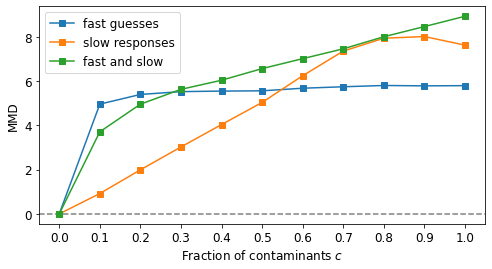

In [27]:
offset= 0.00 #.012
plt.figure(figsize=(8, 4))

plt.axhline(y=MMD_fast[0], color="gray", ls="--")

plt.plot(C[0:]-offset, MMD_fast[0:], marker='s', label="fast guesses")
plt.plot(C[0:], MMD_slow[0:], marker='s', label="slow responses")
plt.plot(C[0:]+offset, MMD_fast_slow[0:], marker='s', label="fast and slow")

plt.xlabel(r"Fraction of contaminants $c$")
plt.ylabel("MMD")
plt.xticks(C)
#plt.ylim(0)
plt.legend(loc='upper left')
plt.savefig(f"plots/abf_dm_mmd_summary_all.{FILEFORMAT}")
plt.show()